<a href="https://colab.research.google.com/github/noriko-hiroi/Machine-Learning-application/blob/main/Copy2classification_training_pytorch_tokkuman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

本ノートブックは深層学習フレームワーク　Chainer　を用いて実装した classification_training.ipynb を PyTorch に移植したものです。

# CNNによる画像分類

画像分類とは、画像の種類や状態を定量的に解析して特定のクラスに分類するタスクである。  
ここでは、細胞画像を生細胞と死細胞に分類するタスクを学習するためのCNNを構築し、訓練および評価までの一連の作業を行う。

## ランタイムの設定
画面上部の「ランタイム」メニューから「ランタイムのタイプを変更」を選択し、「ハードウェアアクセラレータ」 から 「GPU」 を選択し、「保存」 をクリックする。これにより、以降の学習、推定に高速なGPUが使用されるようになる。
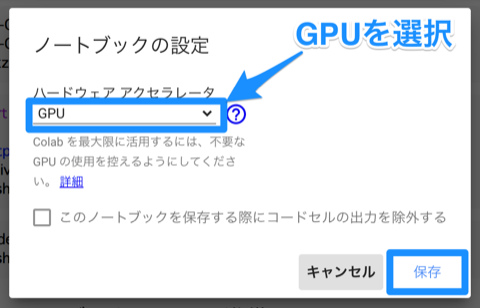

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセット

`dataset_cls/` にHeLa細胞の位相差顕微鏡画像300枚 (生細胞150枚, 死細胞150枚) が格納されている。  
画像サイズはすべて 128x128 pixel で、グレースケール画像となっている。  

まず最初に画像を読み込み表示してみる。

In [ ]:
!curl -O 'https://fun.bio.keio.ac.jp/home/tokuoka/Downloads/datasets.tar.gz'
!curl -O 'https://fun.bio.keio.ac.jp/home/tokuoka/Downloads/inference_model'
!tar xzf datasets.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7343k  100 7343k    0     0  3307k      0  0:00:02  0:00:02 --:--:-- 3309k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.8M  100 60.8M    0     0  15.7M      0  0:00:03  0:00:03 --:--:-- 15.6M


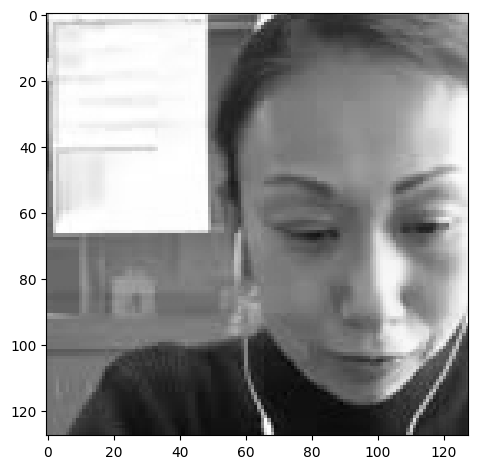

In [ ]:
import skimage.io as io

%matplotlib inline
#img_live = io.imread('./dataset_cls/live/001.tif')
img_live = io.imread('/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/live/001.tif')
io.imshow(img_live)

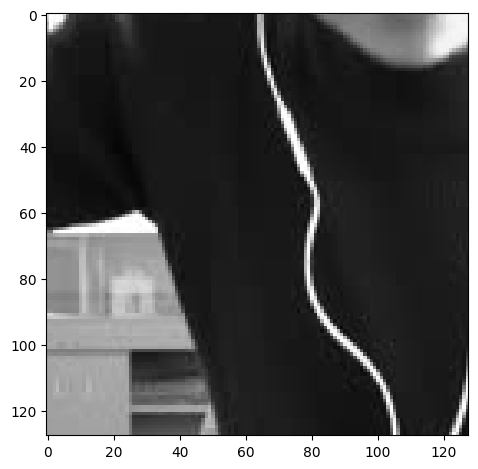

In [ ]:
#img_dead = io.imread('./dataset_cls/dead/001.tif')
img_dead = io.imread('/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/dead/001.tif')
io.imshow(img_dead)

## 学習に用いるデータセットの準備

データセットは、次の３つのカテゴリに分割する必要がある。

* **train**: 訓練に用いるデータセット。学習器はこのデータに対して正しい答えを出力するように学習を行う
* **validation**: 検証に用いるデータセット。訓練データで学習を行った学習器の汎化性を確認するために用いる
* **test**: テストに用いるデータセット。学習に全く関与していないデータでの精度検証が必要となるため、あらかじめテスト用データは分けておく必要がある

それぞれどの画像がどのデータセットにカテゴライズされているか、`datasets/dataset_cls/split_list` にあるテキストファイル (`train.txt`, `validation.txt`, `test.txt`) に記述してある。また、画像分類の学習に用いるデータは、画像とラベル (今回は**死細胞のラベルを0**、**生細胞のラベルを1**とする)　をペアで用意する必要がある。

次のセルでは、画像データを読み込み、画像とラベル (生細胞・死細胞) をペアで用意するためのクラス (関数とデータをまとめたもの) が定義されている。

In [ ]:
import os
import random
import numpy as np
import skimage.io as io
from torch.utils.data import Dataset

class PreprocessedDataset(Dataset):
    def __init__(
            self,
            root_path,
            split_list,
            train=False
    ):
        self.root_path = root_path
        with open(split_list) as f:
            self.split_list = [line.rstrip() for line in f]
        self.dtype = np.float32
        self.train = train

    def __len__(self):
        return len(self.split_list)

    # 画像を返す
    def _get_image(self, i):
        image = io.imread(os.path.join(self.root_path, self.split_list[i]))
        image = self._min_max_normalize_one_image(image)
        if self.train:
            image = self._augmentation_image(image)
        return np.expand_dims(image.astype(self.dtype), axis=0)

    # 画像を[0, 1]に正規化
    def _min_max_normalize_one_image(self, image):
        max_int = image.max()
        min_int = image.min()
        out = (image.astype(np.float32) - min_int) / (max_int - min_int)
        return out

    # 画像を回転 and/or 反転
    def _augmentation_image(self, image):
        image = np.rot90(image, random.randint(0, 3))
        if random.randint(0, 1):
            image = np.fliplr(image)
        return image
    
    # ラベル (生:1, 死: 0) を返す
    def _get_label(self, i):
        label = 0 if 'dead' in self.split_list[i] else 1
        return label

    # 画像とそれに紐づいたラベル (生:1, 死: 0) を返す
    def __getitem__(self, i):
        x, y = self._get_image(i), self._get_label(i)
        return x, y

このクラスでは、引数に渡した `split_list` (`train.txt`, `validation.txt`, `test.txt`のどれか) に従って、画像とラベルのペアを出力するための `__getitem__()` 関数が用意してある。実際に、`__getitem__()` を次のように動かしてみる。

Text(0.5, 1.0, 'label: 0')

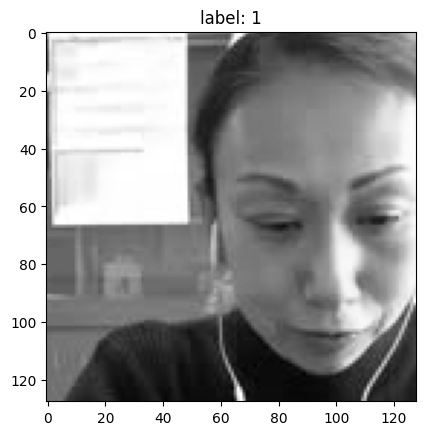

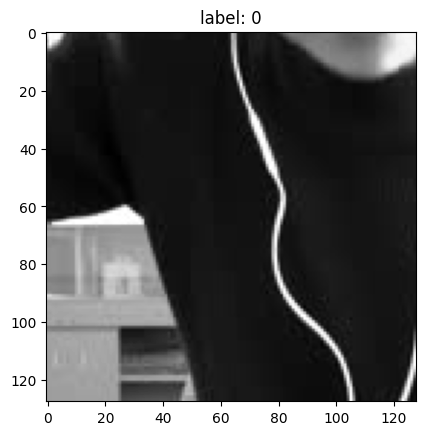

In [ ]:
import matplotlib.pylab as plt

#root_path = './dataset_cls'
root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
split_list = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/train.txt'

dataset = PreprocessedDataset(root_path, split_list)

%matplotlib inline
# train.txtの0番目の画像とラベルを取得
img, label = dataset.__getitem__(0)
plt.figure()
plt.imshow(img[0], cmap='gray')
plt.title('label: {}'.format(label))

# train.txtの80番目の画像とラベルを取得
img, label = dataset.__getitem__(80)
plt.figure()
plt.imshow(img[0], cmap='gray')
plt.title('label: {}'.format(label))

この結果から、画像とラベルが正しい組み合わせで取得できていることが確認できる。

## CNNモデルの定義

画像分類を行うCNNは、畳み込み層と全結合層に分かれている。畳み込み層は `nn.Conv2d(in_ch, out_ch, ksize, stride, pad)` ,
全結合層は  `nn.Linear(in_ch, out_ch)` のように記述する。ここで指定する値は、モデルの構造を決定するパラメータ、すなわちハイパーパラメータとよばれる。

```
    in_ch:   入力チャネル数
    out_ch:  出力チャネル数
    ksize:   畳み込みカーネルサイズ
    stride:  カーネルの移動サイズ
    pad:     パディングサイズ
```

また、順伝搬されたデータを正規化するための層を正規化層とよび、
`nn.BatchNorm2d(in_ch)` のように記述する。

参考: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

ここまで説明した層 (畳み込み層,  全結合層, 正規化層) はすべてパラメータを持っている。  
一方で、パラメータを持たない、つまり学習によって更新されない層や関数が存在する。

CNNにおいてよく用いられる次元削減を行うための層としてプーリング層がある。
プーリング層は `nn.MaxPool2d(ksize, stride)` のように記述する。

参考: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

また、代表的な活性化関数としてReLU (Rectified Linear Unit) があり、`nn.ReLU()` と記述することができる。

参考: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

In [ ]:
import torch
from torch import nn

class ClassificationModel(nn.Module):
    def __init__(self, n_class=2):
        super(ClassificationModel, self).__init__()
        # ネットワークの部品 (層) を用意
        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc5 = nn.Linear(16384, 1024)
        self.fc6 = nn.Linear(1024, n_class)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
            
    def forward(self, x):
        # 各層を接続
        x = x.clone().detach()
        h = self.relu(self.conv1(x))
        h = self.pool(self.bn1(h))
        h = self.relu(self.conv2(h))
        h = self.pool(self.bn2(h))
        h = self.relu(self.conv3(h))
        h = self.pool(self.bn3(h))
        h = self.relu(self.conv4(h))
        h = self.pool(self.bn4(h))
        h = self.dropout(self.relu(self.fc5(h.view(h.shape[0],-1))))
        return self.fc6(h)

## 出力関数

ここまででCNNモデルに用いられる関数と伝搬の仕方を定義したが、最後の出力される層には別の関数を用いる。この出力関数を用いることで、問題に応じた値の範囲になるように調節することができる。一般的に、分類問題では出力関数に**Softmax**関数が用いられる。Softmax関数は、$d$次元のベクトル${\bf y} \in \mathbb{R}^d$が与えられたとき、その各次元の値の合計が1になるように正規化されるため、確率分布のような出力となる。
${\bf y}$の$i$番目の次元を$y_i$とすると、Softmax関数は以下のように定義される。

$$
{\rm Softmax}({\bf y})_i = \frac{\exp(y_i)}{\sum_{j=1}^d \exp(y_j)}
$$

このように表現されるSoftmax関数を出力関数として用いる場合、`F.softmax` と記述する。

参考: https://docs.chainer.org/en/stable/reference/generated/chainer.functions.softmax.html

## CNNモデルによる推論

ここまでで、学習に用いるデータセットとCNNモデルを用意することができた。まずはこれらを用いて、実際に画像分類の推論ができるのか試してみる。

In [ ]:
import torch.nn.functional as F

root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
split_list = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/test.txt'

# データセットを用意
test_dataset = PreprocessedDataset(root_path, split_list, train=False)

# 未学習のモデルを作成
model = ClassificationModel(n_class=2)

print('=====================')
for i in range(5):
    with torch.no_grad():
        # テスト画像とラベルを1セット取得
        img, label = test_dataset.__getitem__(i)
        # テスト画像の生死を推論
        pred = model(torch.tensor(np.expand_dims(img, axis=0)))
        # 出力関数により生・死の確率を求める
        pred = F.softmax(pred, dim=1)

    print('test {}'.format(i + 1))
    print('  pred: {}'.format(np.argmax(pred.data)))     # 確率が高い方のラベルを表示
    print('  label: {}'.format(label))                                   # 正解のラベルを表示
    print('=====================')

test 1
  pred: 0
  label: 1
test 2
  pred: 0
  label: 1
test 3
  pred: 0
  label: 1
test 4
  pred: 0
  label: 1
test 5
  pred: 1
  label: 1


このように、画像をCNNモデルに入力して、出力された結果から画像分類の推論を確認することができる。ただ、このCNNモデルは学習が行われていない状態なので、画像分類の結果もランダムに出力した結果とさほど変わらないことがわかる。

それでは次項から学習を行うための準備を行っていく。

## 目的関数

ここでは、上で定義したCNNモデルの目的関数 (誤差関数, 損失関数ともよばれる) を定義する。目的関数はタスクごとに設定し、分類問題の場合は **Softmax Cross Entropy** 関数を用いるのが一般的である。Softmax Cross Entropy関数は、Softmax関数とCross Entropy関数を組み合わせた関数である。
Softmax関数は上述したため、ここではCross Entropy (交差エントロピー) 関数について説明する。
$N$クラスの分類問題の場合 (今回の例では 2 クラスなので $N = 2$)、ある入力$x$が与えられたとき、ニューラルネットワークの出力層には$N$個のノードが存在する。この出力層の$N$個のノードはそれぞれ$n$番目のクラスに属する確率$y_n$をあらわしている。
また、$x$が属するクラスの正解が、${\bf t} = \begin{bmatrix} t_1 & t_2 & \dots & t_N \end{bmatrix}^T$というベクトルで与えられているとする。
このベクトルは $t_n (n = 1, 2, \dots, N)$ のいずれか1つだけが1であり、
それ以外は0のベクトル (1-hot ベクトル) である。
この値が1となっている要素は、そのインデックス $n$ に対応したクラスが正解であることを意味しており、今回の例では生細胞ならば $t=\begin{bmatrix}0 & 1\end{bmatrix}^T$、細胞ならば $t=\begin{bmatrix}1 & 0\end{bmatrix}^T$ となる。
このとき、Cross Entropy関数は、以下のように定義される。

$$
{\rm Cross\ Entropy}({\bf y}, {\bf t}) = - \frac{1}{N} \sum_{n=1}^{N}t_{n}\log({\rm Softmax}({\bf y})_{n})
$$

このように表現されるSoftmax Cross Entropy関数を目的関数として用いる場合、`nn.CrossEntropyLoss` と `F.Softmax` を組み合わせる。

参考: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

## 最適化手法

ニューラルネットワークにおける学習は、上述した目的関数を最小化するために最適化を行う必要がある。
この最適化手法は勾配法がベースとなっており、学習時に用いる最適化手法はこれまでに数多く提案されている (参考: https://qiita.com/tokkuman/items/1944c00415d129ca0ee9 )。

Chainerにも多くの最適化手法が実装されているが、今回はその中でも最も用いられている**Adam**という最適化手法を採用する。  
Adamを用いる場合には、`optim.Adam` と記述する。

参考: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

## CNNモデルの学習

CNNモデルに目的関数を定義して、最適化手法も決定したため、実際に学習を行ってみる。

## 画像分類精度の評価指標

一般的に、分類問題の精度は**Accuracy**という指標で評価される。Accuracyは全画像のうち何枚の画像を正しく分類できたかを割合であらわされる指標である。すなわち、Accuracyが高いほど分類精度も高いということになる。 
正解クラスが$i$である画像をCNNモデルがクラス$j$に分類した数を$N_{ij}$とすると、クラス数が$k$のとき、Accuracyは以下のように定義される。

$$
{\rm Accuracy} = \frac{\sum_{i=1}^k N_{ii}}{\sum_{i=1}^k \sum_{j=1}^k N_{ij}}
$$

Accuracyを用いる場合、`F.accuracy` と記述する。

参考: https://docs.chainer.org/en/stable/reference/generated/chainer.functions.accuracy.html

## Accuracyを指標とした学習

In [ ]:
import os
import json
import torch
from torch import optim
from torch.utils.data import DataLoader
from sklearn import metrics

class Trainer(object):

    def __init__(self, root_path, train_path, val_path, batchsize, epoch, out='result_cls', device=-1, eval_metrics='accuracy'):

        # train データセットを用意
        train_dataset = PreprocessedDataset(root_path, train_path, train=True)
        # validation データセットを用意
        val_dataset = PreprocessedDataset(root_path, val_path, train=False)
        
        # 未学習のモデルを作成
        self.model = ClassificationModel(n_class=2).to(torch.device(device))

        # 最適化手法を選択 (Adam)
        self.optimizer = optim.Adam(params=self.model.parameters())

        # train データセットを学習器に渡す形式に変換
        self.train_iter = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
        # validation データセットを学習器に渡す形式に変換
        self.val_iter = DataLoader(dataset=val_dataset, batch_size=batchsize, shuffle=False)

        self.epoch = epoch
        self.out = out
        os.makedirs(out, exist_ok=True)
        self.device = device
        self._best_accuracy = 0.0
        self.eval_metrics = eval_metrics
        self.lossfun = nn.CrossEntropyLoss()
        self.results = {}

    def train(self):
        for epoch in range(1, self.epoch + 1):
            print('[epoch {}]'.format(epoch))
            loss_train, eval_results_train = self._train_step(self.model, self.train_iter)
            loss_val, eval_results_val = self._val_step(self.model, self.val_iter)
            self._save_log(epoch, loss_train, loss_val, eval_results_train, eval_results_val)

            if self.best_eval_result(eval_results_val):
                torch.save(self.model.to('cpu'), os.path.join(self.out, 'best_model.npz'))
                self.model.to(torch.device(self.device))
                best_epoch = epoch
                print("Saved better model selected by validation.")
        print('best {}: {}'.format(self.eval_metrics, self._best_accuracy))
        print('best epoch: {}'.format(best_epoch))

    def _train_step(self, model, data_iterator):
        model.train()
        output_list, truth_list, loss_list = [], [], []
        for batch in data_iterator:
            input, label = batch
            self.optimizer.zero_grad()
            pred = model(input.to(torch.device(self.device)))
            output_list.append(pred.to(torch.device('cpu')).clone().detach())
            truth_list.append(label.clone().detach())
            label = label.type(torch.LongTensor)
            loss = self.lossfun(pred.squeeze(1), label.to(torch.device(self.device)).view(len(label)))
            loss_list.append(loss.to(torch.device('cpu')).clone().detach())
            loss.backward()
            self.optimizer.step()
        eval_results = self.evaluate(output_list, truth_list)
        loss_train = float(abs(np.mean(loss_list)))
        print('train loss: {}'.format(loss_train))
        return loss_train, eval_results

    def _val_step(self, model, data_iterator):
        model.eval()
        output_list, truth_list, loss_list = [], [], []
        for batch in data_iterator:
            input, label = batch
            with torch.no_grad():
                pred = model(input.to(torch.device(self.device)))
            output_list.append(pred.to(torch.device('cpu')).clone().detach())
            truth_list.append(label.clone().detach())
            label = label.type(torch.LongTensor)
            loss = self.lossfun(pred.squeeze(1), label.to(torch.device(self.device)).view(len(label)))
            loss_list.append(loss.to(torch.device('cpu')).clone().detach().numpy())
        eval_results = self.evaluate(output_list, truth_list)
        print("[{}] {}, loss: {}".format("validation", self.print_eval_results(eval_results), abs(np.mean(loss_list))))
        return abs(np.mean(loss_list)), eval_results

    def evaluate(self, predict, truth):
        y_trues, y_preds = [], []
        for y_true, logit in zip(truth, predict):
            y_true = y_true.cpu().numpy()
            y_pred = np.argmax(F.softmax(logit, dim=1), axis=1)
            y_trues.append(y_true)
            y_preds.append(y_pred)
        y_true = np.concatenate(y_trues, axis=0)
        y_pred = np.concatenate(y_preds, axis=0).reshape(len(y_true), 1)
        accuracy = metrics.accuracy_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred, pos_label=1)
        recall = metrics.recall_score(y_true, y_pred, pos_label=1)
        f1 = metrics.f1_score(y_true, y_pred, pos_label=1)
        return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

    def print_eval_results(self, results):
        return ", ".join(
            [str(key) + "=" + "{:.4f}".format(value)
             for key, value in results.items()])

    def best_eval_result(self, eval_results):
        assert self.eval_metrics in eval_results, \
            "Evaluation doesn't contain metrics '{}'." \
            .format(self.eval_metrics)

        accuracy = eval_results[self.eval_metrics]
        if accuracy >= self._best_accuracy:
            self._best_accuracy = accuracy
            return True
        else:
            return False

    def _save_log(self, epoch, loss_train, loss_val, eval_results_train, eval_results_val):
        result_each_epoch = {}
        result_each_epoch['epoch'] = epoch
        result_each_epoch['main/loss'] = float(loss_train)
        result_each_epoch['main/accuracy'] = float(eval_results_train["accuracy"])
        result_each_epoch['main/precision'] = float(eval_results_train["precision"])
        result_each_epoch['main/recall'] = float(eval_results_train["recall"])
        result_each_epoch['main/f1'] = float(eval_results_train["f1"])
        result_each_epoch['val/main/loss'] = float(loss_val)
        result_each_epoch['val/main/accuracy'] = float(eval_results_val["accuracy"])
        result_each_epoch['val/main/precision'] = float(eval_results_val["precision"])
        result_each_epoch['val/main/recall'] = float(eval_results_val["recall"])
        result_each_epoch['val/main/f1'] = float(eval_results_val["f1"])
        self.results[epoch] = result_each_epoch
        with open(os.path.join(self.out, 'log'), 'w') as f:
            json.dump(self.results, f, indent=4)

In [ ]:
os.makedirs('results', exist_ok=True)
root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
train_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/train.txt'
val_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/validation.txt'
batchsize = 10
epoch = 10
device = "cuda:0"   # or "cpu"
eval_metrics = "accuracy"

trainer = Trainer(root_path, train_path, val_path, batchsize, epoch, out='results/result_cls_1', device=device, eval_metrics=eval_metrics)

# 訓練開始
trainer.train()

[epoch 1]
train loss: 2.0852468013763428
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 34.702545166015625
Saved better model selected by validation.
[epoch 2]
train loss: 0.20035335421562195
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 41.90748977661133
Saved better model selected by validation.
[epoch 3]
train loss: 0.7154204845428467
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 36.70246887207031
Saved better model selected by validation.
[epoch 4]
train loss: 0.8724734783172607
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 11.856513023376465
Saved better model selected by validation.
[epoch 5]
train loss: 0.5335482358932495
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 9.113838314078748e-05
Saved better model selected by validation.
[epoch 6]
train loss: 0.5120028853416443
[validation] accuracy=0.8000, precision=0.

## テストデータを用いた画像分類の精度

学習器は訓練データに対して最小の誤差となるように学習を進める。一方で、今回学習器に解かせたい分類問題は、分類精度 (Accuracy) が高いモデルこそが最良のモデルであることは明らかである。そのため、訓練データで誤差が最小になるように学習を進め、検証データで分類精度が最高となるモデルを得るのが理想的である。以下のセルでは、誤差が最小となった際に保存したモデルと分類精度が最高になった際に保存したモデルの精度を、テストデータを用いて検証する。

In [ ]:
import numpy as np
import torch

def test(root_path, test_path, model_path, out='results/result_cls_test', device=-1):

    # データセットを用意
    test_dataset = PreprocessedDataset(root_path, test_path, train=False)
    
    # 学習済みモデルの読み込み
    model = torch.load(model_path)
    
    true_conut = 0
    for i in range(test_dataset.__len__()):
        with torch.no_grad():
            # テスト画像とラベルを1セット取得
            x, t = test_dataset.__getitem__(i)
            # テスト画像の生死を推論
            # y = model(np.expand_dims(x, axis=0))
            y = model(torch.tensor(np.expand_dims(x, axis=0)))
        # 推論した分類結果が正解ラベルと一致していたら true_count　に1を加算
        if np.argmax(y.data) == t:
            true_conut += 1
    # accuracy を算出
    accuracy = true_conut / test_dataset.__len__()
    os.makedirs(out, exist_ok=True)
    with open(os.path.join(out, 'result.txt'), 'w') as f:
        f.write('accuracy: {}\n'.format(accuracy))
    print('accuracy: {}'.format(accuracy))
    
    
root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
test_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/test.txt'

# 検証精度が最高の学習済みモデルでテスト
print('Test for best accuracy model')
model_path = 'results/result_cls_1/best_model.npz'
# test(root_path, test_path, model_path, 'results/result_cls_1_test', device=-1) # CPU
test(root_path, test_path, model_path, 'results/result_cls_1_test', device=0) # GPU

Test for best accuracy model
accuracy: 1.0


## 5分割交差検証 (5-fold cross validation)

交差検証 (cross validation) とは、学習の妥当性を検証・確認するための手法である。
K-分割交差検証 (K-fold cross validation) では、データセットをK個に分割する。
次に、分割した1つのデータセットを検証データとし、残る  K - 1個を訓練データとする。
交差検証は、K 個に分割されたデータセットをそれぞれ検証データとして K 回検証を行う。
このようにして得られた K 回の結果を平均することで、データセット全体に対してうまく学習できているか評価を行うことができる。

In [ ]:
# 5分割交差検証の設定
root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
batchsize = 10
epoch = 300
eval_metrics = "accuracy"
device = "cuda:0"   # or "cpu"

## fold 1

In [ ]:
train_path_fold1 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold1/train.txt'
val_path_fold1 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold1/validation.txt'

trainer_fold1 = Trainer(root_path, train_path_fold1, val_path_fold1, batchsize, epoch=epoch, out='results/result_cls_fold1', device=device, eval_metrics=eval_metrics) # GPU
trainer_fold1.train()

[epoch 1]
train loss: 2.55830717086792
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 36.75230407714844
Saved better model selected by validation.
[epoch 2]
train loss: 1.0276563167572021
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 53.58109664916992
Saved better model selected by validation.
[epoch 3]
train loss: 1.0508177280426025
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 60.956790924072266
Saved better model selected by validation.
[epoch 4]
train loss: 0.3362218141555786
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 58.00792694091797
Saved better model selected by validation.
[epoch 5]
train loss: 0.5518208742141724
[validation] accuracy=0.5750, precision=0.5405, recall=1.0000, f1=0.7018, loss: 30.434429168701172
Saved better model selected by validation.
[epoch 6]
train loss: 0.13017413020133972
[validation] accuracy=0.1500, precision=0.0000, 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.9568862915039062
[validation] accuracy=0.3000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 44.79930877685547
[epoch 48]
train loss: 0.0
[validation] accuracy=0.6000, precision=0.5556, recall=1.0000, f1=0.7143, loss: 110.06855010986328
[epoch 49]
train loss: 0.0
[validation] accuracy=0.6000, precision=0.5556, recall=1.0000, f1=0.7143, loss: 118.01690673828125
[epoch 50]
train loss: 0.0
[validation] accuracy=0.5500, precision=0.5263, recall=1.0000, f1=0.6897, loss: 133.1375732421875
[epoch 51]
train loss: 0.0
[validation] accuracy=0.5750, precision=0.5405, recall=1.0000, f1=0.7018, loss: 120.94967651367188
[epoch 52]
train loss: 0.2775525152683258
[validation] accuracy=0.7000, precision=0.6250, recall=1.0000, f1=0.7692, loss: 37.89879608154297
[epoch 53]
train loss: 9.826543418967049e-07
[validation] accuracy=0.6500, precision=0.5882, recall=1.0000, f1=0.7407, loss: 66.57615661621094
[epoch 54]
train loss: 0.0
[validation] accuracy=0.6500, precision=0.5882, recall=1.0

## fold 2

In [ ]:
train_path_fold2 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold2/train.txt'
val_path_fold2 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold2/validation.txt'

trainer_fold2 = Trainer(root_path, train_path_fold2, val_path_fold2, batchsize, epoch=epoch, out='results/result_cls_fold2', device=device, eval_metrics=eval_metrics)
trainer_fold2.train()

[epoch 1]
train loss: 2.509092092514038
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 30.99974822998047
Saved better model selected by validation.
[epoch 2]
train loss: 1.1256740093231201
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 26.438234329223633
Saved better model selected by validation.
[epoch 3]
train loss: 0.6191281676292419
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 32.80744171142578
Saved better model selected by validation.
[epoch 4]
train loss: 0.07022050023078918
[validation] accuracy=0.9250, precision=0.8696, recall=1.0000, f1=0.9302, loss: 0.601877748966217
Saved better model selected by validation.
[epoch 5]
train loss: 0.5160245895385742
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 1.4901156752955558e-08
Saved better model selected by validation.
[epoch 6]
train loss: 0.510478138923645
[validation] accuracy=0.5000, precision=0.00

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.0637764930725098
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.001352221705019474
Saved better model selected by validation.
[epoch 8]
train loss: 2.3720874786376953
[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 5.4895920753479
[epoch 9]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.18168509006500244
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 10]
train loss: 0.13041271269321442
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 3.963682502217125e-07
Saved better model selected by validation.
[epoch 11]
train loss: 0.12095493823289871
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.004286323674023151
Saved better model selected by validation.
[epoch 12]
train loss: 0.23693475127220154
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 13]
train loss: 0.5176891088485718
[validation] accuracy=0.8500, precision=0.7692, recall=1.0000, f1=0.8696, loss: 0.5953569412231445
[epoch 14]
train loss: 0.9023197293281555
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected b

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.9890928268432617
[validation] accuracy=0.5500, precision=0.5263, recall=1.0000, f1=0.6897, loss: 106.63108825683594
[epoch 152]
train loss: 0.11656570434570312
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 153]
train loss: 2.386364698410034
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 154]
train loss: 3.540529251098633
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 200.32049560546875
[epoch 155]
train loss: 2.273221492767334
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 156]
train loss: 0.5802104473114014
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 157]
train loss: 0.2548667788505554
[valida

## fold 3

In [ ]:
train_path_fold3 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold3/train.txt'
val_path_fold3 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold3/validation.txt'

trainer_fold3 = Trainer(root_path, train_path_fold3, val_path_fold3, batchsize, epoch=epoch, out='results/result_cls_fold3', device=device, eval_metrics=eval_metrics)
trainer_fold3.train()

[epoch 1]
train loss: 2.893657684326172
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 18.205894470214844
Saved better model selected by validation.
[epoch 2]
train loss: 0.5198428630828857
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 23.954448699951172
Saved better model selected by validation.
[epoch 3]
train loss: 0.78801429271698
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 11.933416366577148
Saved better model selected by validation.
[epoch 4]
train loss: 0.6938745975494385
[validation] accuracy=0.7500, precision=0.6667, recall=1.0000, f1=0.8000, loss: 2.43350887298584
Saved better model selected by validation.
[epoch 5]
train loss: 0.14937733113765717
[validation] accuracy=0.7500, precision=0.6667, recall=1.0000, f1=0.8000, loss: 4.0688886642456055
Saved better model selected by validation.
[epoch 6]
train loss: 0.10853731632232666
[validation] accuracy=1.0000, precision=1.0000,

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.5525345802307129
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 17]
train loss: 0.35142529010772705
[validation] accuracy=0.6000, precision=1.0000, recall=0.2000, f1=0.3333, loss: 11.063315391540527
[epoch 18]
train loss: 0.2299432009458542
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 19]
train loss: 0.047175802290439606
[validation] accuracy=0.5250, precision=0.5128, recall=1.0000, f1=0.6780, loss: 28.55205535888672
[epoch 20]
train loss: 0.49339208006858826
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 21]
train loss: 0.0
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 22]
train loss: 0.2693650424480438
[validation] accuracy=1

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 2.2082295417785645
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 54.09494400024414
[epoch 25]
train loss: 0.8248285055160522
[validation] accuracy=0.6000, precision=0.5556, recall=1.0000, f1=0.7143, loss: 16.430763244628906
[epoch 26]
train loss: 0.6569108366966248
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 27]
train loss: 1.8957455158233643
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 28]
train loss: 0.31507641077041626
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 29]
train loss: 0.25856509804725647
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 30]
train loss: 0.04692130535840988
[validati

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.0104966163635254
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 71]
train loss: 3.472161054611206
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 72]
train loss: 3.290386915206909
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 73]
train loss: 0.46597519516944885


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 1496.733642578125
[epoch 74]
train loss: 2.110539674758911
[validation] accuracy=0.9750, precision=0.9524, recall=1.0000, f1=0.9756, loss: 2.2931036949157715
[epoch 75]
train loss: 3.5582940578460693
[validation] accuracy=0.8750, precision=0.8000, recall=1.0000, f1=0.8889, loss: 4.588327884674072
[epoch 76]
train loss: 4.648277282714844
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 77]
train loss: 1.3589726686477661
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 78]
train loss: 1.7614244222640991
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 79]
train loss: 1.2580664157867432
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, 

## fold 4

In [ ]:
train_path_fold4 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold4/train.txt'
val_path_fold4 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold4/validation.txt'

trainer_fold4 = Trainer(root_path, train_path_fold4, val_path_fold4, batchsize, epoch=epoch, out='results/result_cls_fold4', device=device, eval_metrics=eval_metrics)
trainer_fold4.train()

[epoch 1]
train loss: 1.821276068687439
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 27.22006607055664
Saved better model selected by validation.
[epoch 2]
train loss: 0.42914867401123047
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 47.68342208862305
Saved better model selected by validation.
[epoch 3]
train loss: 0.0008236849098466337
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 20.211109161376953
Saved better model selected by validation.
[epoch 4]
train loss: 0.21689338982105255
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 3.278254467886654e-08
Saved better model selected by validation.
[epoch 5]
train loss: 1.679574966430664
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 6]
train loss: 0.4602360427379608
[validation] accuracy=1.0000, precision=1.0000, recall=

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 1.1221895217895508
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 12]
train loss: 0.9024574756622314
[validation] accuracy=0.8000, precision=1.0000, recall=0.6000, f1=0.7500, loss: 2.930938959121704
[epoch 13]
train loss: 0.6522163152694702
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 14]
train loss: 0.15618999302387238
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 15]
train loss: 0.2637299597263336
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 16]
train loss: 0.3479079306125641
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 17]
train loss: 2.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 3.711461305618286
[validation] accuracy=0.5750, precision=1.0000, recall=0.1500, f1=0.2609, loss: 30.308059692382812
[epoch 136]
train loss: 0.902678906917572
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 137]
train loss: 2.153621196746826
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 138]
train loss: 3.962735176086426
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 139]
train loss: 6.607203960418701
[validation] accuracy=0.9250, precision=1.0000, recall=0.8500, f1=0.9189, loss: 1.9283071756362915
[epoch 140]
train loss: 8.256059646606445
[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 425.14898681640625
[epoch 141]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 2.384491443634033
[validation] accuracy=0.5000, precision=0.0000, recall=0.0000, f1=0.0000, loss: 257.80987548828125
[epoch 142]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss: 0.0
[validation] accuracy=0.5250, precision=1.0000, recall=0.0500, f1=0.0952, loss: 24.181350708007812
[epoch 143]
train loss: 3.0265450477600098
[validation] accuracy=0.9000, precision=1.0000, recall=0.8000, f1=0.8889, loss: 3.3025949001312256
[epoch 144]
train loss: 2.810551166534424
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 145]
train loss: 4.379179000854492
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 146]
train loss: 0.0
[validation] accuracy=0.8500, precision=0.7692, recall=1.0000, f1=0.8696, loss: 6.2254838943481445
[epoch 147]
train loss: 0.0
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved better model selected by validation.
[epoch 148]
train loss: 0.0
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.0
Saved bette

## fold 5

In [ ]:
train_path_fold5 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold5/train.txt'
val_path_fold5 = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/fold5/validation.txt'

trainer_fold5 = Trainer(root_path, train_path_fold5, val_path_fold5, batchsize, epoch=epoch, out='results/result_cls_fold5', device=device, eval_metrics=eval_metrics)
trainer_fold5.train()

[epoch 1]
train loss: 1.3534963130950928
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 30.49510955810547
Saved better model selected by validation.
[epoch 2]
train loss: 0.9082821607589722
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 63.74089813232422
Saved better model selected by validation.
[epoch 3]
train loss: 1.87302827835083
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 52.100887298583984
Saved better model selected by validation.
[epoch 4]
train loss: 1.4411799907684326
[validation] accuracy=0.5000, precision=0.5000, recall=1.0000, f1=0.6667, loss: 15.91649341583252
Saved better model selected by validation.
[epoch 5]
train loss: 0.7742242217063904
[validation] accuracy=1.0000, precision=1.0000, recall=1.0000, f1=1.0000, loss: 0.016950109973549843
Saved better model selected by validation.
[epoch 6]
train loss: 0.06691376864910126
[validation] accuracy=0.5000, precision=0.5000

## Cross Validationの評価

ここまでで各foldでの検証データに対する精度が得られたことになるので、5分割交差検証の評価を行い、最良のモデルを選択する。次のセルを実行することで、各foldの実行結果を読み込み、epochごとの訓練データ、検証データに対する分類精度のプロットを行う。

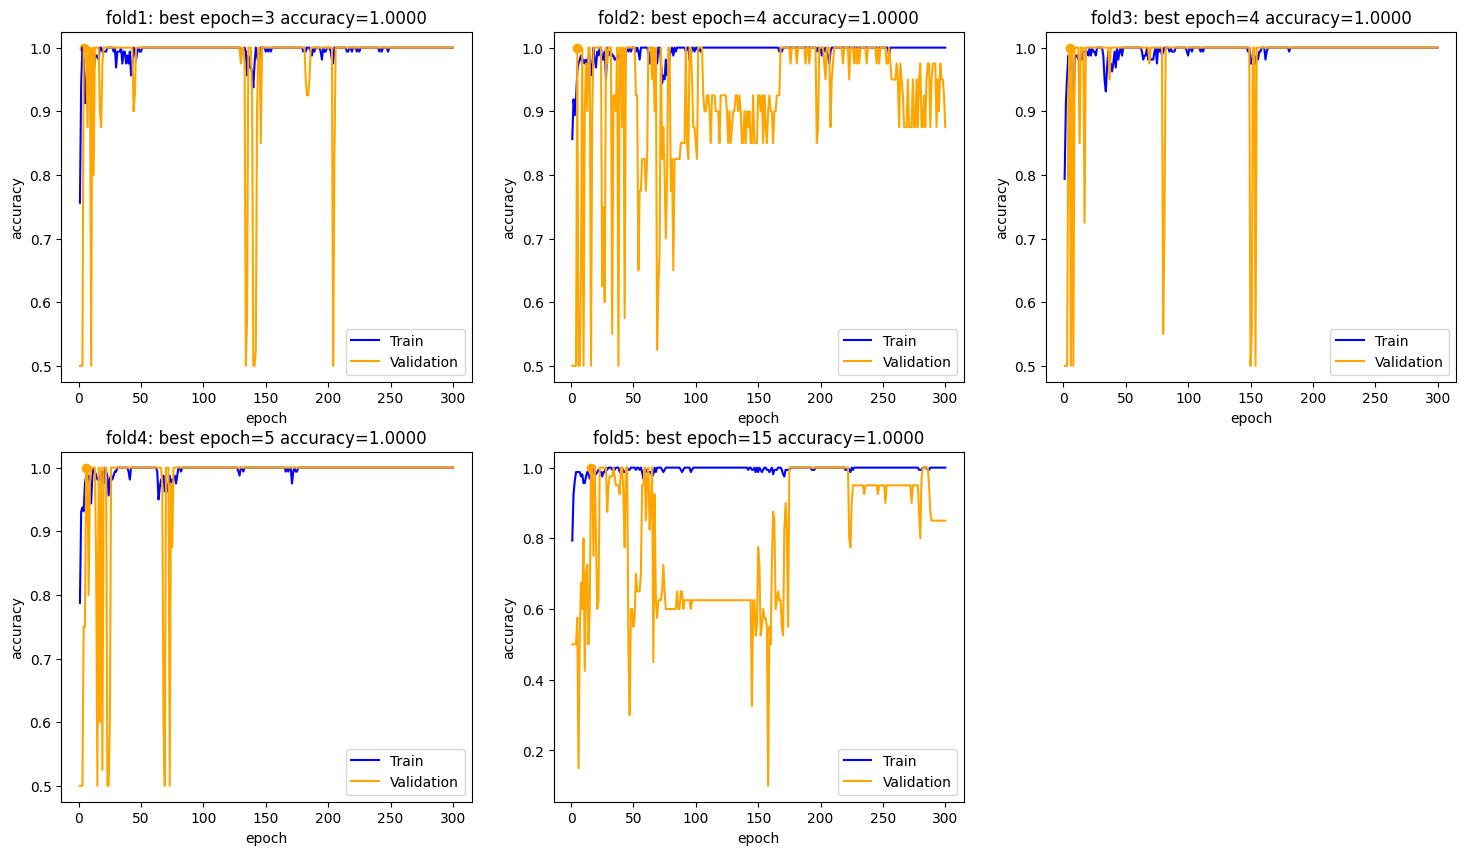

In [ ]:
import os
import glob
import json
import matplotlib.pylab as plt

res_cv_path = glob.glob('results/result_cls_fold*')
res_log = []
for cv in res_cv_path:
    with open(os.path.join(cv, 'log'), 'r') as f:
        res_log.append(json.load(f))

%matplotlib inline
    
plt.figure(figsize=(18, 10))
for k in range(len(res_log)):
    train, val, epoch = [], [], []
    for n in range(1, len(res_log[k])+1):
        train.append(res_log[k][str(n)]['main/accuracy'])
        val.append(res_log[k][str(n)]['val/main/accuracy'])
        epoch.append(res_log[k][str(n)]['epoch'])
    plt.subplot(2, 3, k+1)
    plt.plot(epoch, train, label='Train', color='blue')
    plt.plot(epoch, val, label='Validation', color='orange')
    plt.scatter(np.argmax(val)+1, np.max(val), marker='o', color='orange')
    # plt.xticks(epoch)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('fold{}: best epoch={} accuracy={:.4f}'.format(k+1, np.argmax(val), np.max(val)))
    plt.legend()

この結果から、各foldの学習におけるepochごとのAccuracyを確認することができる。また、各プロットの上部に、どのepochで最高の分類精度が得られたかが表示されている。この結果を確認することで、テストデータによる検証に用いるべき、最高の分類精度を達成したfoldのモデルを選択することができる。

# テストデータによる検証

5分割交差検証により、検証データにて最高の分類精度を示す学習済みモデル (上のセルの結果において、最も精度の高いfoldのモデル) が得られた。最後に、学習に全く関与させていないテストデー タを用いて、学習済みモデルの精度を検証する。

## テスト関数の作成

In [ ]:
import numpy as np
import torch

def test(root_path, test_path, model_path, out='results/result_cls_test', device=-1):
    test_dataset = PreprocessedDataset(root_path, test_path, train=False)
    
    model = torch.load(model_path)
    
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(test_dataset.__len__()):
        with torch.no_grad():
            x, t = test_dataset.__getitem__(i)
            y = model(torch.tensor(np.expand_dims(x, axis=0)))
        if np.argmax(y.data) == t:
            if t == 1:
                tp += 1
            else:
                tn += 1
        else:
            if t == 1:
                fn += 1
            else:
                fp += 1
            
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = 2 * precision * recall / (precision + recall)
    
    os.makedirs(out, exist_ok=True)
    with open(os.path.join(out, 'result.txt'), 'w') as f:
        f.write('accuracy: {}\n'.format(accuracy))
        f.write('precision: {}\n'.format(precision))
        f.write('recall: {}\n'.format(recall))
        f.write('f-score: {}\n'.format(fscore))
    print('accuracy: {}'.format(accuracy))
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('f-score: {}'.format(fscore))

## テスト

以下のセルを実行することで、今回の5分割交差検証において得られた最良の学習モデルのテストデータに対する生細胞・死細胞の分類精度が示される。

In [ ]:
root_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls'
test_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/split_list/test.txt'
model_path = 'results/result_cls_fold2/best_model.npz'  # 最も精度の高いfoldのモデルを選択

test(root_path, test_path, model_path, 'results/result_cls_test', device="cuda:0")

accuracy: 1.0
precision: 1.0
recall: 1.0
f-score: 1.0


#**Grad-CAMの実装** 

セットアップ

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

最後の畳み込み層の名前を取得

In [ ]:
import torch

model = ClassificationModel()
print(model)

ClassificationModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=16384, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=2, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch
import torch.nn as nn

# モデルを定義する
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        return x

# モデルを初期化し、最後の畳み込み層を見つける
model = MyNet()
last_conv_layer_name = None
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        last_conv_layer_name = name

print("最後の畳み込み層の名前: ", last_conv_layer_name)

最後の畳み込み層の名前:  conv3


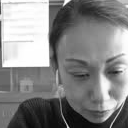

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
from PIL import Image
img_path = '/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/live/100.tif'
with Image.open(img_path) as img:
    img.show()


Grad-CAMのアルゴリズム

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 240x320
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (240, 320, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 240, 320, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 1s/step
Predicted: [('n04317175', 'stethoscope', 5.2411585)]


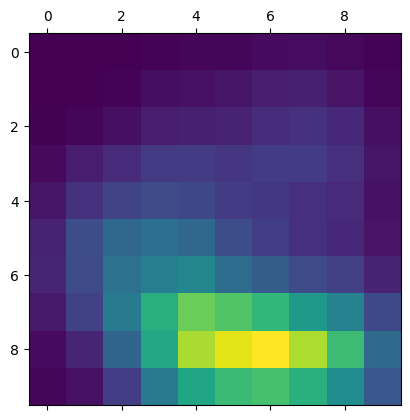

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

オーバーレイ表示表示

In [ ]:
print(img_path)
print(img)
print(heatmap)
print(cam_path)

/content/drive/MyDrive/Colab_Notebooks/tokkuma_datasets/dataset_cls/live/100.tif
<PIL.TiffImagePlugin.TiffImageFile image mode=L size=128x128 at 0x7F68550C4B20>
[[0.00000000e+00 0.00000000e+00 5.76970633e-04 9.41283721e-03
  1.28366649e-02 1.52223501e-02 3.07156835e-02 3.51127796e-02
  2.19301898e-02 8.65657628e-03]
 [0.00000000e+00 2.77306652e-03 9.66533739e-03 3.74287739e-02
  4.67823856e-02 5.54440990e-02 8.26441795e-02 8.83159414e-02
  5.30706458e-02 1.60750300e-02]
 [4.29714611e-03 1.79580748e-02 4.13353927e-02 7.94309378e-02
  8.60100910e-02 9.72106084e-02 1.28786132e-01 1.44318357e-01
  1.12026013e-01 4.22318131e-02]
 [2.38727182e-02 7.60427415e-02 1.20606847e-01 1.71213463e-01
  1.74300238e-01 1.58718303e-01 1.76229939e-01 1.73449129e-01
  1.39672339e-01 5.54620251e-02]
 [5.69872968e-02 1.44886285e-01 2.03888923e-01 2.29077548e-01
  2.17016384e-01 1.78331167e-01 1.63571164e-01 1.38539985e-01
  1.18410259e-01 4.99943160e-02]
 [1.01295173e-01 2.34917507e-01 3.39406699e-01 3.64888

<ipython-input-66-5bb8588ddf02>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


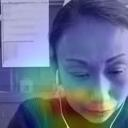

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path = 'cam.jpg', alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)